# Table of Contents
* [1. Comparando 2 grupos](#1.-Comparando-2-grupos)
	* [1.1 Analizando los resultados](#1.1-Analizando-los-resultados)
	* [1.2 Probability of superiority](#1.2-Probability-of-superiority)
	* [1.3 Posterior predictive check](#1.3-Posterior-predictive-check)
	* [1.4 ejercicios](#1.4-ejercicios)
* [2. Comparando más de 2 grupos](#2.-Comparando-más-de-2-grupos)
	* [2.1 "ANOVA" Bayesiano o "Banova".](#2.1-"ANOVA"-Bayesiano-o-"Banova".)
	* [2.2 ANCOVA](#2.2-ANCOVA)
* [3. Para seguir leyendo](#3.-Para-seguir-leyendo)


In [16]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
from plot_post import plot_post
import pandas as pd  # importar pandas

# 1. Comparando 2 grupos

Un problema común al analizar datos consiste en comparar dos grupos de datos al hacernos preguntas como, ¿Cúan diferentes son dos grupos? ¿Podemos asegurar, razonablemente, que la diferencia es distinta de cero? ¿Cúan seguros podemos estar de que la diferencia sea tal o cual valor?. Contestar estas preguntas de apariencia trivial rápidamente se vuelve algo sutil, al darnos cuenta que no solo debemos comparar las medias si no que es necesario tener en cuenta la variabilidad de los datos y que siempre que trabajemos con datos reales hay un nivel de incerteza asociado a la medición de esos datos. Como veremos la estadística Bayesiana permite de forma simple y flexible aproximarse a responder a estas preguntas.

Los frecuentistas resuelven este problema mediante lo que se conoce como t-test. Basicamente hacen algunos supuestos como que los datos siguen una distribución normal y luego calculan un estimador o estadístico, resulta que este estimador sigue (bajo ciertos supuestos) una distribución t de Student (de ahí la **t** en **t**-test). 

Nosotros no vamos a hacer esto (ni entrar en detalles de como funciona este método frecuentista). Lo que haremos será usar la distribución t de Student, pero de forma diferente. Nosotros vamos a asumir que son los datos quienes siguen una distribución t de Student con $nu$ (el parámetro que determina la _normalidad_ desconocido). Es decir si los datos así lo indican $nu$ tomará un valor alto y estaremos frente a una distribución prácticamente normal, caso contrario tendremos una curva con colas más largas/gordas que una Gaussiana. En general no será la estimación de $nu$ quien nos interese si no las estimacioens de la media y desviación estandard de cada distribución t (una por cada grupo), que usaremos para entender si difieren y como lo hacen los 2 grupos. 

Como es una análisis Bayesiano será necesario, además especificar los _a prioris_. El modelo general que usaremos será:

<img src="imagenes/BEST.png" width=500>

Es interesante notar, que aunque a primera vista no parezca, este modelo puede ser pensado como un caso especial del modelo generalizado lineal (ver capítulo 5) cuya forma general es:

$$\mu = \alpha + \beta x$$

Solo que en nuestro caso $x$ es un indicador nominal de pertenencia a un determinado grupo (control-tratamiento, vegano-omnívoro, colectivero-taxista, etc), por lo que el modelo lineal generalizado queda reducido a:

$$\mu = \alpha_x$$

Vamos a suponer que por alguna extraña razón nos interesa saber si una droga dada tiene efectos en potenciar las capacidades cognitivas en humanos. El experimento consiste en tomar un grupo de personas y realizarles un test de coeficiente intelectual, a la mitad se le administra la droga en cuestión (un cierto tiempo antes de realizar el test) y al resto se les da una placebo. Los datos obtenidos fueron:

In [17]:
y1 = np.array([101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101])  # droga
y2 = np.array([99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99])  # placebo

Siempre que se pueda es buena idea visualizar los datos. Los histogramas, KDEs, boxplots y violinplots, pueden ser usados como un método cualitativo para determinar diferencias entre grupos ya que permiten rápidamente visualizar en simultaneo varias carácterísticas de las distribuciones.

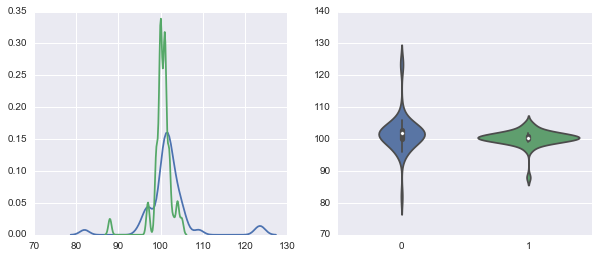

In [18]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.kdeplot(y1)
sns.kdeplot(y2);
plt.subplot(122)
sns.violinplot(data=[y1, y2]);

En el siguiente ejemplo fijaremos _a prioris_ ligeramente informativos que pueden usarse para prácticamente cualquier problema. Como ya dijimos este tipo de _a prioris_ pueden resultar útiles al inicio del modelado de un problema, o cuando realmente no se tiene información sobre el problema, pero  si contamos con información previa entonces seguramente resultará de mucha utilidad incorporarla a nuestro análisis vía los _a prioris_.

In [20]:
with pm.Model() as model:        
    # definimos los a prioris
    grupo1_media = pm.Normal('grupo1_media', mu=np.mean(y1), sd=100)
    grupo2_media = pm.Normal('grupo2_media', mu=np.mean(y2), sd=100)
    grupo1_sd = pm.Uniform('grupo1_sd', lower=0, upper=100)
    grupo2_sd = pm.Uniform('grupo2_sd', lower=0, upper=100)
    nu = pm.Exponential('nu', 1/30)

    # definimos el likelihood
    grupo1 = pm.StudentT('grupo1', nu=nu, mu=grupo1_media, sd=grupo1_sd, observed=y1) # droga
    grupo2 = pm.StudentT('grupo2', nu=nu, mu=grupo2_media, sd=grupo2_sd, observed=y2) # placebo

    dif_medias = pm.Deterministic('dif_medias', grupo1_media - grupo2_media)
    dif_sds = pm.Deterministic('dif_sds', grupo1_sd - grupo2_sd)
    d_cohen = pm.Deterministic('d_cohen', dif_medias / 
                                   pm.sqrt((grupo1_sd**2 + grupo2_sd**2) / 2))

    step = pm.Metropolis()
    trace = pm.sample(10000, step)

Applied interval-transform to grupo1_sd and added transformed grupo1_sd_interval to model.
Applied interval-transform to grupo2_sd and added transformed grupo2_sd_interval to model.
Applied log-transform to nu and added transformed nu_log to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 6.9 sec

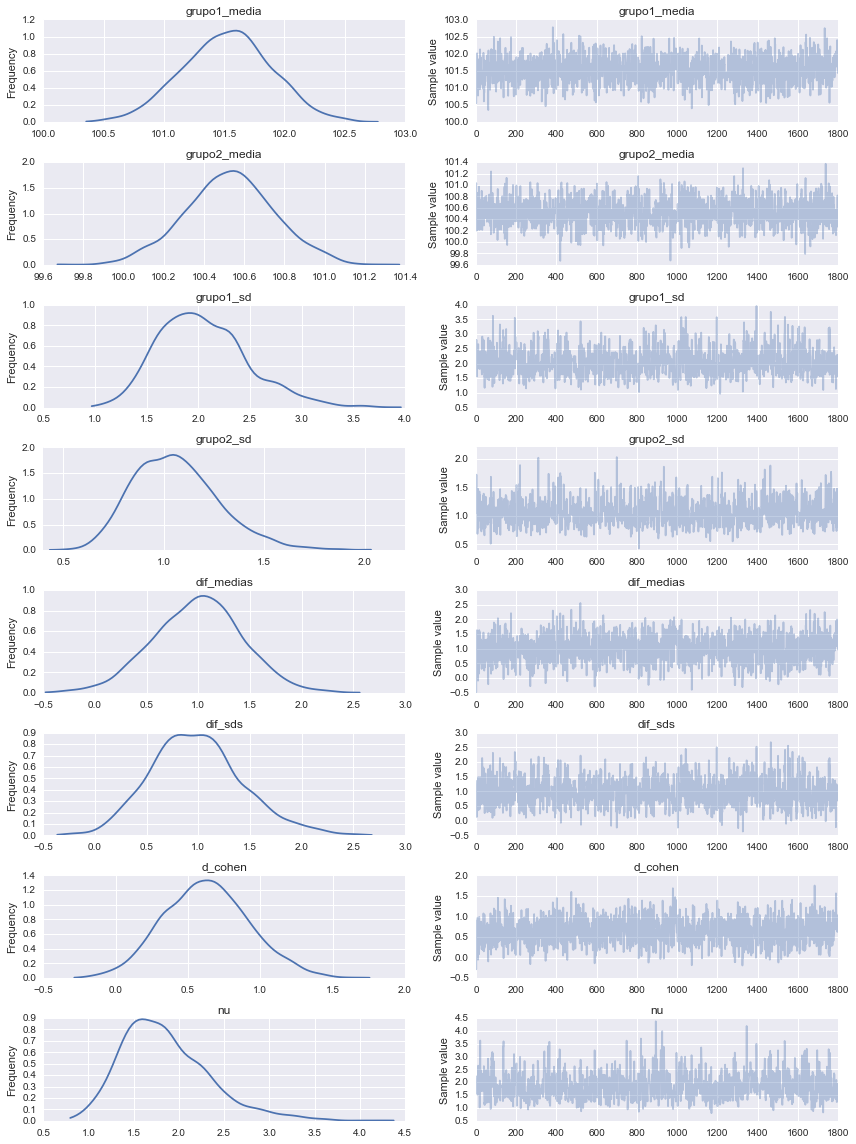

In [21]:
vars=[grupo1_media, grupo2_media, grupo1_sd, grupo2_sd, dif_medias, dif_sds, d_cohen, nu]
cadena = trace[1000::5]
pm.traceplot(cadena, vars=vars);

In [22]:
#pm.plots.summary(cadena, vars=vars)

In [23]:
#pm.autocorrplot(cadena, vars=vars);

In [24]:
#pm.summary(cadena,vars=[efecto])

## 1.1 Analizando los resultados

Es importante recordar que un análisis bayesiano devuelve la distribución completa de valores creibles (dado los datos y el modelo). Muchas veces resulta conveniente convertir esta distribución continua en decisiones discretas, por ejemplo para contestar la pregunta ¿Son las medias de los grupo diferentes entre si?
En el siguiente gráfico es posible ver que el 98% por cierto de la distribución marginal para el _a posteriori_ de las diferencias de medias está por encima de 0 y que en promedio esa diferencia está alrededor 1. Por lo tanto podemos concluir que lo más probable es que las medias no sean iguales y que es muy probable que la diferencia entre las medias sea de 1, con un HDI95 entre ~0,1 y 1,9.

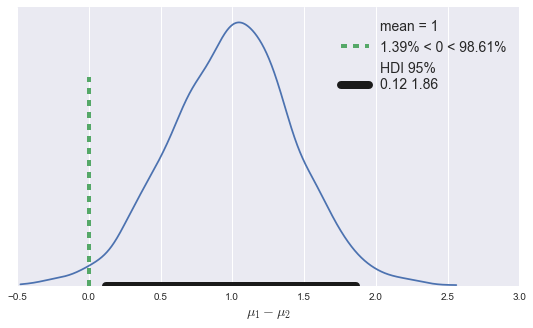

In [25]:
plt.figure(figsize=(9,5))
plot_post(cadena['dif_medias'], show_mode=False, xlab='$\mu_1-\mu_2$', comp_val=0);

Un análisis similar se puede hacer para las diferencias de desviaciones estandard. En el siguiente gráfico se puede ver que la desviación estandard del primer grupo (el que recibió la droga) es superior a la del grupo control. Estos junto con la diferencia entre las medias de los grupos nos estaría diciendo que por un lado la droga es efectiva en promedio para aumentar el IQ, pero que al mismo tiempo introduce mayor dispersión entre los individuos es decir a algunos individuos los afecta negativamente mientras que a otros positivamente.

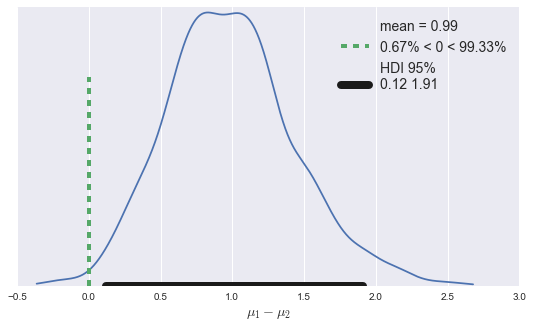

In [26]:
plt.figure(figsize=(9,5))
plot_post(cadena['dif_sds'], show_mode=False, xlab='$\mu_1-\mu_2$', comp_val=0);

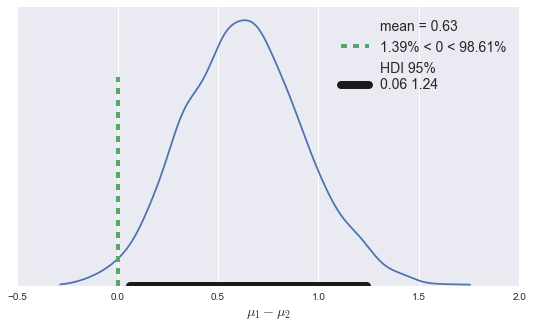

In [27]:
plt.figure(figsize=(9,5))
plot_post(cadena['d_cohen'], show_mode=False, xlab='$\mu_1-\mu_2$', comp_val=0);

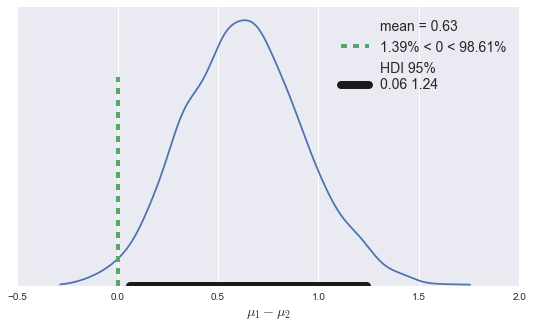

In [28]:
plt.figure(figsize=(9,5))
plot_post(cadena['d_cohen'], show_mode=False, xlab='$\mu_1-\mu_2$', comp_val=0);

Es común que estudios como este terminen en titulares periodísticos del estilo "Descruben droga revolucionaria que haría a la humanidad más inteligente: El fin del cambio climatico, las guerras y el hambre cada vez más cerca".

A fin de tratar de evitar que eso suceda, y _a riesgo_ de que nuestro paper termine publicado en una revista _de no tan buena calidad_, o incluso de encontrar que no hay nada que publicar. Es necesario poner los resultados en contexto, como vimos la droga si tendría un efecto sobre el IQ (dados nuestros datos y el modelo), pero por un lado no todos los individuos se ven igualmente beneficiados y segundo el fecto en promedio es de 1 punto de IQ, un valor que no es realmente alto. Es decir aún cuando el análisis Bayesiano nos dice que los grupos difieren en sus medias y desviaciones estandard, la magnitud con que difieren podría ser considerada marginal o relevante dependiendo del contexto en el que se realizó experimento.

Una forma de formalizar esto es midiendo el tamaño del efecto observado. Existen muchas posibles forma de medir el tamañan de un efecto (el coeficiente de correlación de Person _r_ es una de ellas). Una expresión muy usada cuando se comparan medias es usar lo que se concoe como _d de Cohen_, que se calcula como

$$ \frac{\mu_1 - \mu_2}{\sqrt{\left(\frac{sd_1^2 + sd_2^2}{2}\right)}}$$

Es decir, el tamaño del efecto es calculado como la diferencia de las medias sobre la desviación estandard promedio. Introducir la variabilidad de los grupos (y no solo las medias) es importante, por que como vimos antes, un aumento o disminución que en promedio es de $x$ unidades puede ser explicado como que todos los individuos cambiaron exactamente $x$, o que la mitad cambio 0 y la otra mitad $2x$ (u otras combinaciones). Por lo tanto tener en cuenta la variabilidad de ambos grupos es crucial. 

El tamaño del efecto calculado de esta se puede interpretar como un _Z-score_ (asumiendo normalidad). Por ejemplo un efecto de 0.6 quiere decir que la respuesta promedio obtenida en el tratamiento está 0.65 desviaciones estandard por encima que la repuesta promedio en el grupo control.

Otro detalla a tener en cuenta es que, dado que nuestro cálculo es bayesiano, el _tamaño del efecto_ es computado a partir del _a posteriori_, es decir para cada punto de la hipersuperficie del _a posteriori_ calculamos el tamaño del efecto, obteniendo la distribución de valores más probables (dado los datos y el modelo). En la literatura el d de cohen se calcula usando un promedio pesado (según la cantidad de datos en cada grupo) para estimar la desviacion estandard promedio. Este promedio pesado, bajo el supuesto de igualdad de varianzas para ambas poblaciones, permite estimar con mayor precisión la varianza, que usar cualquiera de las dos varianzas. Dado que nosotros computamos el d de cohen como parte de la inferencia Bayesiana (es decir a partir del _a posteriori_), no es necesario hacer correcciones segun el tamaño de la muestra.

## 1.2 Probability of superiority

This is effect size with many names: common language effect size (CL), Area under the receiver operating characteristics (AUC) or just A for its non-parametric version (Ruscio & Mullen, 2012). It is meant to be more intuitive for persons without any training in statistics. The effect size gives the probability that a person picked at random from the treatment group will have a higher score than a person picked at random from the control group. Cohen's d can be converted CL using the following formula (Ruscio, 2008)
CL=Φ(δ2√)

http://www.leeds.ac.uk/educol/documents/00002182.htm

## 1.3 Posterior predictive check

dibujar distribuciones t sobre el histograma del grupo 1 por un lado y del grupo 2 por el otro.

## 1.4 ejercicios

Para el siguiente conjunto de datos repetir el análisis antes realizado.

1) Muestra _pequeña_ tomada de una distribución normal standard.

    y1 = [0.99, 0.35, 1.14, 1.65, 1.04, -0.46, 2.93, 2.35]
    y2 = [-1.25, -0.19, -0.42, 1.80, 0.90,  0.68, -1.31, -0.20]

1) Muestra _grande_ tomada de una distribución normal standard.

    y1 = np.random.normal(size=1000)
    y2 = np.random.normal(size=1000)

# 2. Comparando más de 2 grupos

Así como puede interesarnos comparar dos grupos puede que no interese comparar más de dos grupo. Vamos a ver dos formas de hacer esto:

1. Extender el modelo anterior
2. Construir un análogo bayesiano del método frecuentista ANOVA

Usaremos un conjunto de datos provisto por _seaborn_. Vamos a ver si hay diferencia entre las propinas recibidas 

In [ ]:
tips

In [38]:
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [58]:
tips['tip_p'] =  tips['tip'] / tips['total_bill'] * 100
tips.head()

,total_bill,tip,sex,smoker,day,time,size,tip_p
0,16.99,1.01,Female,No,Sun,Dinner,2,5.944673
1,10.34,1.66,Male,No,Sun,Dinner,3,16.054159
2,21.01,3.50,Male,No,Sun,Dinner,3,16.658734
3,23.68,3.31,Male,No,Sun,Dinner,2,13.978041
4,24.59,3.61,Female,No,Sun,Dinner,4,14.680765


In [39]:
y = tips['tip_p'].values
x = pd.Categorical(tips['day']).labels

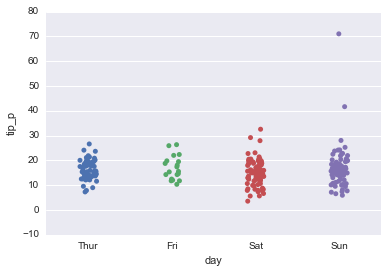

In [64]:
#sns.boxplot(x="day", y="tip_p", data=tips);
sns.stripplot(x="day", y="tip_p", data=tips, jitter=True);

In [66]:
with pm.Model() as model:        
    # definimos los a prioris
    grupos_media = pm.Normal('grupos_media', mu=y.mean(), sd=10, shape=4)
    grupos_sd = pm.Uniform('grupos_sd', lower=0, upper=10, shape=4)
    nu0 = pm.Exponential('nu0', 1/29)
    nu = pm.Deterministic('nu', nu0 + 1)

    # definimos el likelihood
    yl = pm.StudentT('yl', nu=nu, mu=grupos_media[x], sd=grupos_sd[x], observed=y)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(5000, step, start)

Applied interval-transform to grupos_sd and added transformed grupos_sd_interval to model.
Applied log-transform to nu0 and added transformed nu0_log to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 12.9 sec

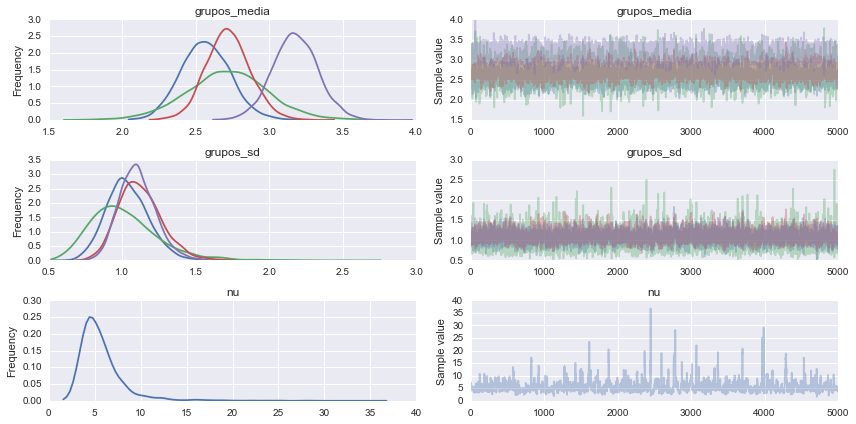

In [67]:
cadena = trace[::]
varsname = ['grupos_media', 'grupos_sd', 'nu',]
pm.traceplot(cadena, varsname);

In [68]:
pm.df_summary(cadena, vars=varsname)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
grupos_media__0,2.567945,0.167510,0.003126,2.238515,2.887145
grupos_media__1,2.713433,0.279880,0.003245,2.157508,3.268643
grupos_media__2,2.720504,0.150880,0.002835,2.414151,3.010323
grupos_media__3,3.176615,0.154521,0.001766,2.871711,3.482424
grupos_sd__0,1.035182,0.144721,0.003685,0.756322,1.313536
grupos_sd__1,1.014629,0.236721,0.003779,0.603673,1.472622
grupos_sd__2,1.121209,0.148557,0.004378,0.858513,1.433055
grupos_sd__3,1.102863,0.124002,0.002556,0.865208,1.349922
nu,5.686884,2.562430,0.122175,2.441547,10.418432


## 2.1 "ANOVA" Bayesiano o "Banova".

En estadística frecuentista este problema se suele resolver recurriendo a un método llamado Análisis de la varianza o ANOVA para los amigos (ANalysis Of VAriance). COmo con la regresión lineal existe una versión de un solo factor (como los ejemplos de arriba) y versiones de dos o más factores. Por ejemplo podríamos además de la dieta agregar la actividad física, si fuma o no, etc. 

El nombre análisis de la varianza proviene de que el procedimiento se base en descomponer (analizar) la varianza en partes, por un lado la varianza dentro de cada grupo respecto de la varianza entre grupos. Nosotros resolveremos el problema desde otra perpectiva, con un método que es similar en varios aspectos ANOVA frecuentista, pero que no es estrictamente un ANOVA, a menos que definamos el término en un sentido bastante amplio (por eso las comillas en el título).

In traditional ANOVA, the null hypothesis assumes (i) the data are normally
distributed within groups, and (ii) the standard deviation of the data within each group
is the same for all groups. The second assumption is sometimes called “homogeneity of
variance.” These assumptions are important for the validity of the methodand the assumptions of normality
and homogeneity of variance should be respected by the data.  These
assumptions of normally distributed data with homogeneous variances are entrenched
in the traditional approach. Fortunately, using the Bayesian framework it is straight forward to relax those assumptions in Bayesian software, where we can use different variance parameters for each group, and use non-normal distributions to describe data within groups, as will be shown later in the chapter.

El "ANOVA" Bayesiano es un modelo lineal generalizado y podemos escribirlo como

$$\mu = \alpha + \sum_i \beta_{i} x_{i}$$

o alternativamente,

$$\mu = \alpha + \beta X$$

Donde $\mu$ es la media de una distribucion Gaussiana (pero como ya hemos visto, podríamos reemplazar facilmente con una distribución t de Student). 

Como se puede ver la forma general es igual a la regresión lineal, y solo difiere de esta en dos aspectos:

* **La variable $x_i$ es nomimal:** Para representar la variable nominal se usa un vector cuya longitud es igual a la cantidad de categorías también llamados _grupos_ o _tratamientos_ (las dietas o estilos musicales en los ejemplos anteriores). Donde por ej $x_1 = [1, 0, 0]$ representa la variable rock, $x_2 = [0, 1, 0]$ jazz y  $x_3 = [0, 0, 1]$ clásica. Es decir si un individuo pertenece al grupo $i$ entonces el elemento i-ésimo del vector será 1 y los demas ceros.

* **Cada categoría se describe como la desviación respecto de una tendencia central o linea de base**: De esta forma los coeficientes $\beta_{i} $ indican cuanto cambia el valor predicho de $y$ cuando $x$ cambia de neutro a la categoría $i$. La linea de base se restringe de forma tal que la suma de desviaciones a lo largo de los diferentes grupos sume cero.

$$\sum_j \beta_{[j]} = 0$$

Una opción al hacer este análisis es usar el siguiente modelo

<img alt="regresión_lineal_simple" src="imagenes/MLG_base.png", width=300>

Este modelo, al igual que el ANOVA frecuentista, asume que $y$ se distribuye de forma normal alrededor de una valor medio para cada grupo y que las varianzas de cada uno de los grupo son totalmente independientes entre si. Por lo tanto si los _a prioris_ se hacen lo suficientemente planos, este modelo dará resultados similares a un ANOVA frecuentista. Estos dos supuestos los podemos relajar en el primer caso podríamos asumir una distribución t de student, en ves de una Gaussiana, a fin de lograr una estimacion robusta a datos alejados de esa media. En el segundo caso podriamos usar un modelo jerárquico y asumir que las varianzas de cada grupo no son totalemente diferentes sino que provienen de una distribución común. En este último caso podríamos usar el siguiente modelo:

<img alt="regresión_lineal_simple" src="imagenes/ANOVA.png", width=300>

En este modelo y siguiendo la recomendación de [Gelman](http://projecteuclid.org/euclid.ba/1340371048) hemos elegido usar una distribución de media-Cauchy como _a priori_. Esta distribución con un valor de escala relativamente alto tiene la ventaja de _permitir que los datos se expresen_ al intentar estimar el grado de contracción incluso cuando la cantidad de grupos es pequeña (menos de 5). Como siempre los resultados deberán ser analizados criticamente, si se encontrase algun problema con este _a priori_ se pueden evaluar otras alternativas como usar una distribución media-t de Student y estimar $\nu$ a partir de los datos (en vez de fijarla $\nu = 1$), usar una distribución media-normal con una varianza alta (por ej 100). En caso que se prefiera un _a priori_ más informativo una distribución gamma puede ser útil. Por supuesto también podría darse el caso en el que usar un modelo jerárquico no es buena idea por ejemplo si un experimento involucrase muchos grupos controles pero un solo tratamiento, las (posiblemente) similares varianzas entre los grupos control provocarían una contracción exagerada de la varianza del tratamiento. El uso de distribuciones con colas gordas como la Cauchy intenta disminuir este riesgo, pero podría ser que quizá convenga no usar un modelo jerárquico en lo absoluto.

In [33]:
with pm.Model() as modelo:
    # define the hyperpriors
    sd_h = pm.HalfCauchy('sd_h', 10)
    # define the priors
    alfa = pm.Normal('alfa', mu=0, sd=10)
    beta_tmp = pm.Normal('beta_tmp', mu=0, sd=sd_h, shape=len(set(x)))
    #beta = pm.Normal('beta', mu=0 , sd=10, shape=len(set(x)))

    epsilon = pm.Uniform('epsilon', 0, 100)
    
    beta = pm.Deterministic('beta', beta_tmp - beta_tmp.mean())
    mu = alfa + beta[x]
    # define the likelihood
    yl = pm.Normal('yl', mu=mu, sd=epsilon, observed=y)
    # Generate a MCMC chain
    step = pm.NUTS()
    trace = pm.sample(5000, step)

Applied log-transform to sd_h and added transformed sd_h_log to model.
Applied interval-transform to epsilon and added transformed epsilon_interval to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 26.5 sec

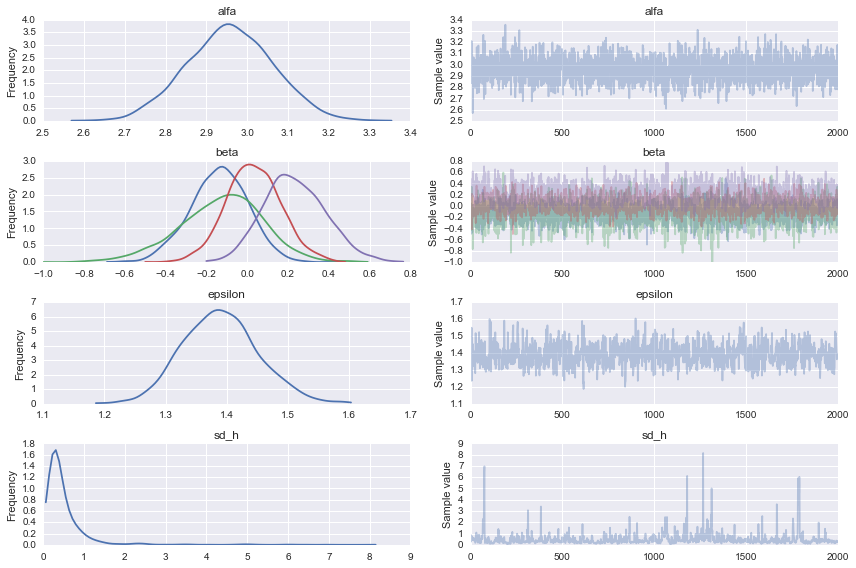

In [34]:
cadena = trace[1000::2]
varsname = ['alfa', 'beta', 'epsilon', 'sd_h']
#varsname = ['alfa', 'beta', 'epsilon']
pm.traceplot(cadena, varsname);

In [35]:
pm.df_summary(cadena, varsname)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alfa,2.958181,0.105588,0.002485,2.755470,3.163522
beta__0,-0.137313,0.141682,0.003232,-0.436403,0.113358
beta__1,-0.126948,0.206785,0.005517,-0.543448,0.268688
beta__2,0.031114,0.133645,0.002699,-0.223815,0.305869
beta__3,0.233147,0.151359,0.004745,-0.044581,0.532891
epsilon,1.389982,0.061373,0.002239,1.274845,1.513416
sd_h,0.501464,0.609642,0.036391,0.078570,1.238486


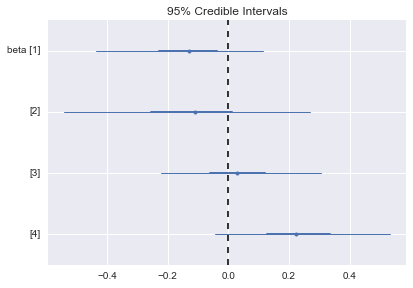

In [36]:
pm.forestplot(cadena, vars=['beta'])

## 2.2 ANCOVA

Asi como se puede hacer una regresión utilizando variables predictoras metricas y variables predictoras nominales, se puede hacer una regresión combinando ambas. Por ejemplo en el caso de las propinas podría ser que el consumo de alcohol está vinculado a mayores propinas (la sospecha es que clientes _más felices_ dan mas propina). En ese caso podríamos incluir una variable que fuese litros de cerveza o algo por el estilo. En estos casos la variable metrica se suele llamar co-variable y suele ser introducida como una variable control. Es decir si realmente existiese una correlación entre consumo de alcohol y tamaño de la propina al incluir esta variable permitira capturar de mejor forma el efecto del día sobre la propina. En un contexto frecuentista este tipo de análisis recibe el nombre de ANCOVA.

# 3. Para seguir leyendo

* La publicación: [Bayesian estimation supersedes the t test. Journal of Experimental Psychology. Kruschke, John. (2012)](www.indiana.edu/~kruschke/BEST/BEST.pdf) incluye una detallada comparación entre el clásico _t-test_ y su versión Bayesiana y las razones para preferir esta última.
* Capítulos 15-16,19-20 de Doing Bayesian Data Analysis de Kruschke (2 [edición](www.amazon.com/gp/product/0124058884))

* Material online con tópicos Bayesianos:
    * [Publishable Stuff](http://sumsar.net/)
    * [Probably Overthinking It](http://allendowney.blogspot.com.ar/)
    * [Pythonic Perambulations](http://jakevdp.github.io./)
    * [While My MCMC Gently Samples](http://twiecki.github.io/)
    * [Count Bayesie](https://www.countbayesie.com/)
    * [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/#contents)   


* Las plantillas utilizadas para generar los diagramas de Kruschke, fueron creadas por [Rasmus Bååth's](http://sumsar.net/blog/2013/10/diy-kruschke-style-diagrams/)
* El código del t-test es una modificación del [modelo portado a PyMC3](http://pymc-devs.github.io/pymc3/BEST/) desde R por Thomas Wiecki.

In [37]:
import sys, IPython, scipy, matplotlib, platform
print("Esta notebook fue creada en una computadora %s corriendo %s y usando:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

Esta notebook fue creada en una computadora x86_64 corriendo Ubuntu 15.10 y usando:
Python 3.5.0
IPython 4.1.0
PyMC3 3.0
NumPy 1.10.4
SciPy 0.17.0
Matplotlib 1.5.1
Seaborn 0.7.0

